In [1]:

from Optimization_Test_Problems import *
import numpy as np
import matplotlib.pyplot as plt
from AtomicKANLayer import AtomicKANLayer
import torch
import torch.nn as nn
from kan import KAN
from sklearn import datasets

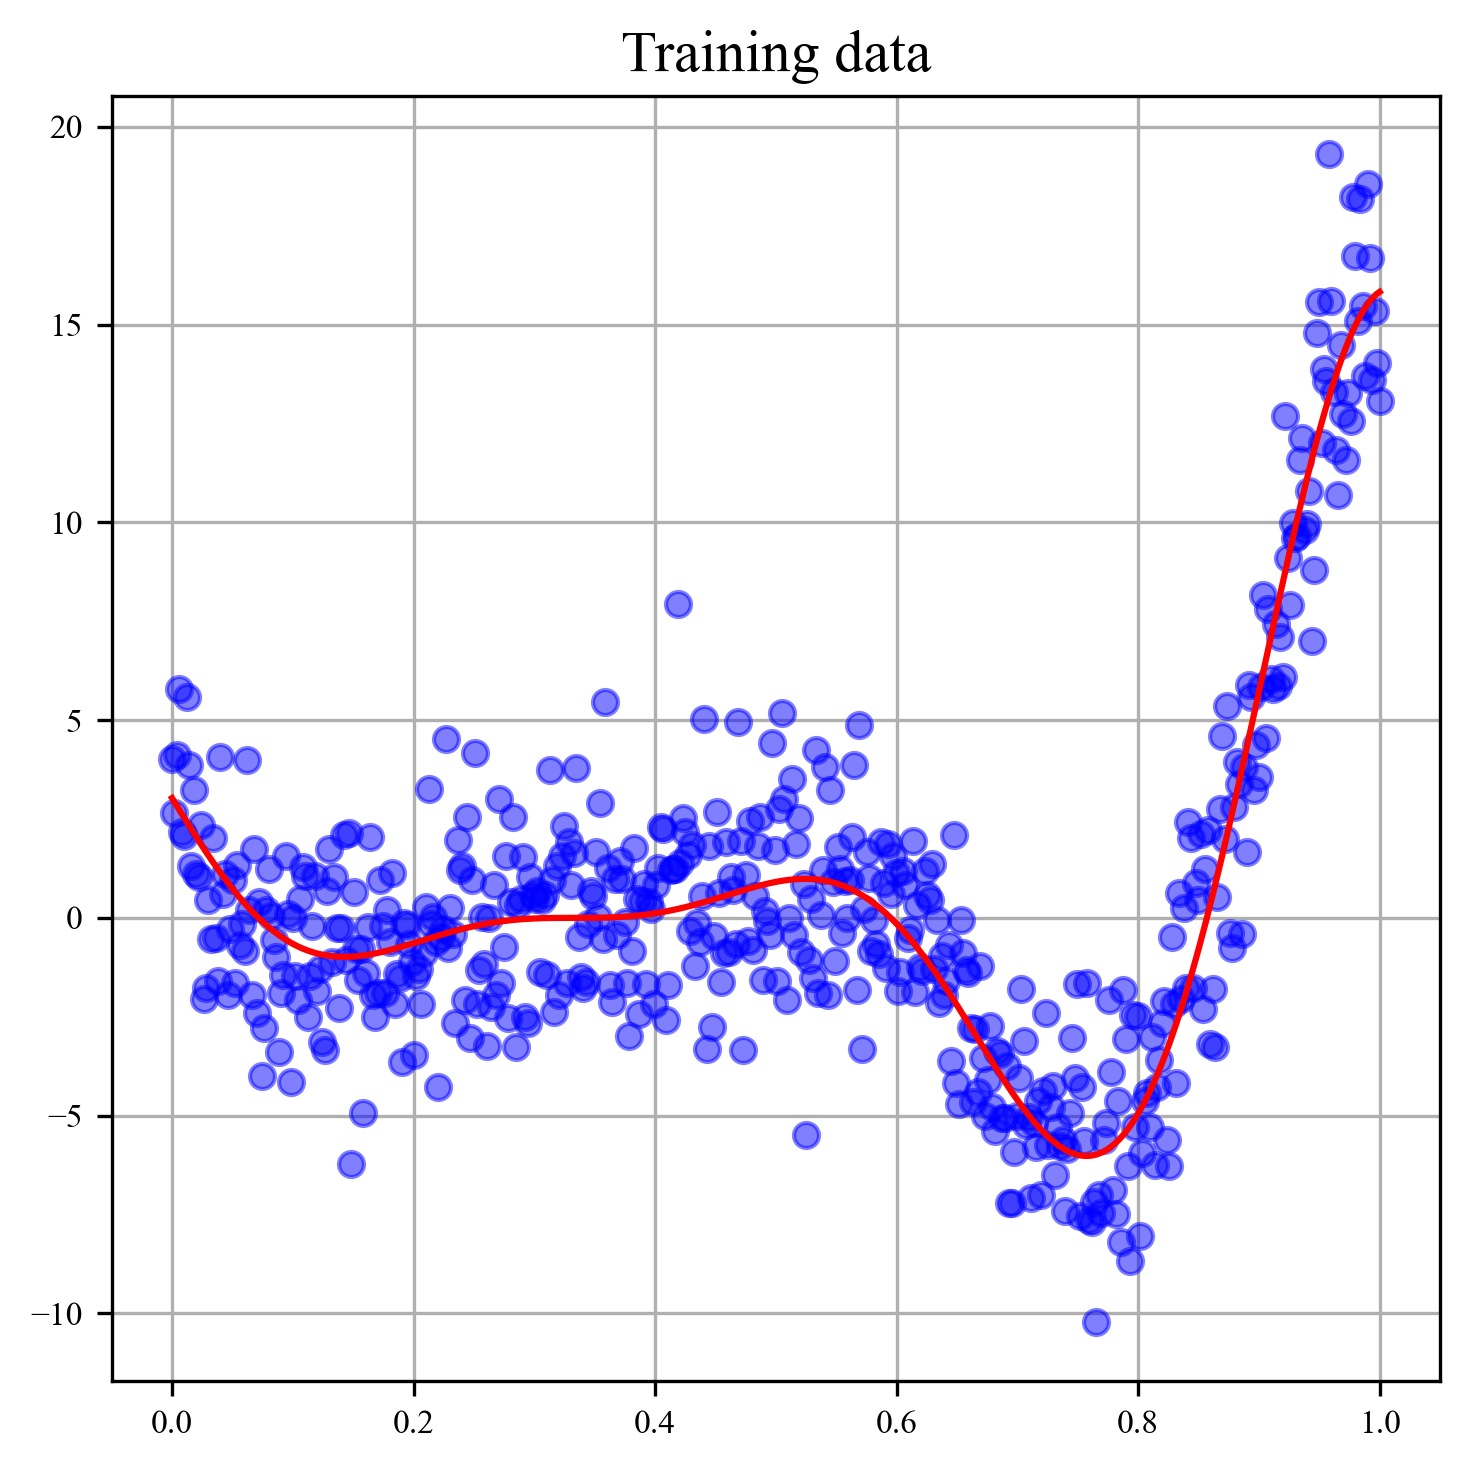

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

def target_function(x):
    # Преобразуем тензор в numpy массив явно
    x_np = x.numpy() if isinstance(x, torch.Tensor) else np.asarray(x, dtype=np.float64)
    y = (6 * x_np - 2) ** 2 * np.sin(12 * x_np - 4)
    # Добавляем шум
    noise = np.random.normal(0, 2, y.shape)
    y += noise
    return y

def target_function2(x):
    # Преобразуем тензор в numpy массив явно
    x_np = x.numpy() if isinstance(x, torch.Tensor) else np.asarray(x, dtype=np.float64)
    y = (6 * x_np - 2) ** 2 * np.sin(12 * x_np - 4)
    return y

# Создаем данные
x_train = torch.linspace(0, 1, 500).unsqueeze(1)

# Правильное создание тензоров без предупреждений
# Вариант 1: Используем torch.from_numpy()
x_train_np = x_train.numpy()
y_train_np = target_function(x_train_np)
y_train = torch.from_numpy(y_train_np).float()

# Или вариант 2: Создаем напрямую
# y_train = torch.tensor(target_function(x_train_np), dtype=torch.float32)

# Визуализация
fig, ax = plt.subplots(figsize=(5,5))

# Преобразуем для построения графика
x_plot = x_train.squeeze().numpy()
y_plot = y_train.squeeze().numpy()

ax.plot(x_plot, y_plot, 'o', color='blue', alpha=0.5)
ax.plot(x_plot, target_function2(x_plot), '-', color='red')
ax.set_title('Training data')
ax.grid()
fig.tight_layout()
plt.show()

In [7]:
bspline_model = KAN(width=[1, 8, 8, 1], grid=8, k=3, seed=42)


optimizer_bspline = torch.optim.Adam(bspline_model.parameters(), lr=0.01)
bspline_losses = []


class AtomicKAN(nn.Module):
    def __init__(self):
        super(AtomicKAN, self).__init__()
        self.atomkan1 = AtomicKANLayer(1, 8, 8)
        self.atomkan2 = AtomicKANLayer(8, 1, 8)

    def forward(self, x):
        x = self.atomkan1(x)
        x = self.atomkan2(x)
        return x

# Instantiate models
atomic_model = AtomicKAN()

# Define loss_bspline function and optimizer_bspline
criterion = nn.MSELoss()
optimizer_atom = torch.optim.Adam(atomic_model.parameters(), lr=0.01)

atom_losses = []


# Train the models
# epochs = 200000
epochs = 300
epoch_step = 10
for epoch in range(epochs):
    optimizer_atom.zero_grad()
    outputs_atom = atomic_model(x_train)
    loss_atom = criterion(outputs_atom, y_train)
    loss_atom.backward()
    optimizer_atom.step()


    optimizer_bspline.zero_grad()
    outputs_bspline = bspline_model(x_train)
    loss_bspline = criterion(outputs_bspline, y_train)
    loss_bspline.backward()
    optimizer_bspline.step()


    if epoch % epoch_step == 0:
        atom_losses.append(loss_atom.item())
        bspline_losses.append(loss_bspline.item())
        print(f'Epoch {epoch + 1}/{epochs}, AtomicKAN Loss: {loss_atom.item():.4f}, BsplineKAN Loss: {loss_bspline.item():.4f}')

# Test the models
x_test = torch.linspace(0, 1, steps=400).unsqueeze(1)
# x_test = torch.linspace(-1, 1, steps=400).unsqueeze(1)
y_pred_atom = atomic_model(x_test).detach()
y_pred_bspline = bspline_model(x_test).detach()

checkpoint directory created: ./model
saving model version 0.0
Epoch 1/300, AtomicKAN Loss: 23.3828, BsplineKAN Loss: 23.3077
Epoch 11/300, AtomicKAN Loss: 22.3942, BsplineKAN Loss: 21.5005
Epoch 21/300, AtomicKAN Loss: 20.2096, BsplineKAN Loss: 17.3856
Epoch 31/300, AtomicKAN Loss: 17.1390, BsplineKAN Loss: 9.9950
Epoch 41/300, AtomicKAN Loss: 13.7526, BsplineKAN Loss: 4.7148
Epoch 51/300, AtomicKAN Loss: 10.8472, BsplineKAN Loss: 3.7775
Epoch 61/300, AtomicKAN Loss: 8.6878, BsplineKAN Loss: 3.8034
Epoch 71/300, AtomicKAN Loss: 6.9434, BsplineKAN Loss: 3.7217
Epoch 81/300, AtomicKAN Loss: 5.6719, BsplineKAN Loss: 3.6993
Epoch 91/300, AtomicKAN Loss: 4.8646, BsplineKAN Loss: 3.6827
Epoch 101/300, AtomicKAN Loss: 4.3994, BsplineKAN Loss: 3.6725
Epoch 111/300, AtomicKAN Loss: 4.1236, BsplineKAN Loss: 3.6635
Epoch 121/300, AtomicKAN Loss: 3.9547, BsplineKAN Loss: 3.6552
Epoch 131/300, AtomicKAN Loss: 3.8584, BsplineKAN Loss: 3.6471
Epoch 141/300, AtomicKAN Loss: 3.8034, BsplineKAN Loss: 3

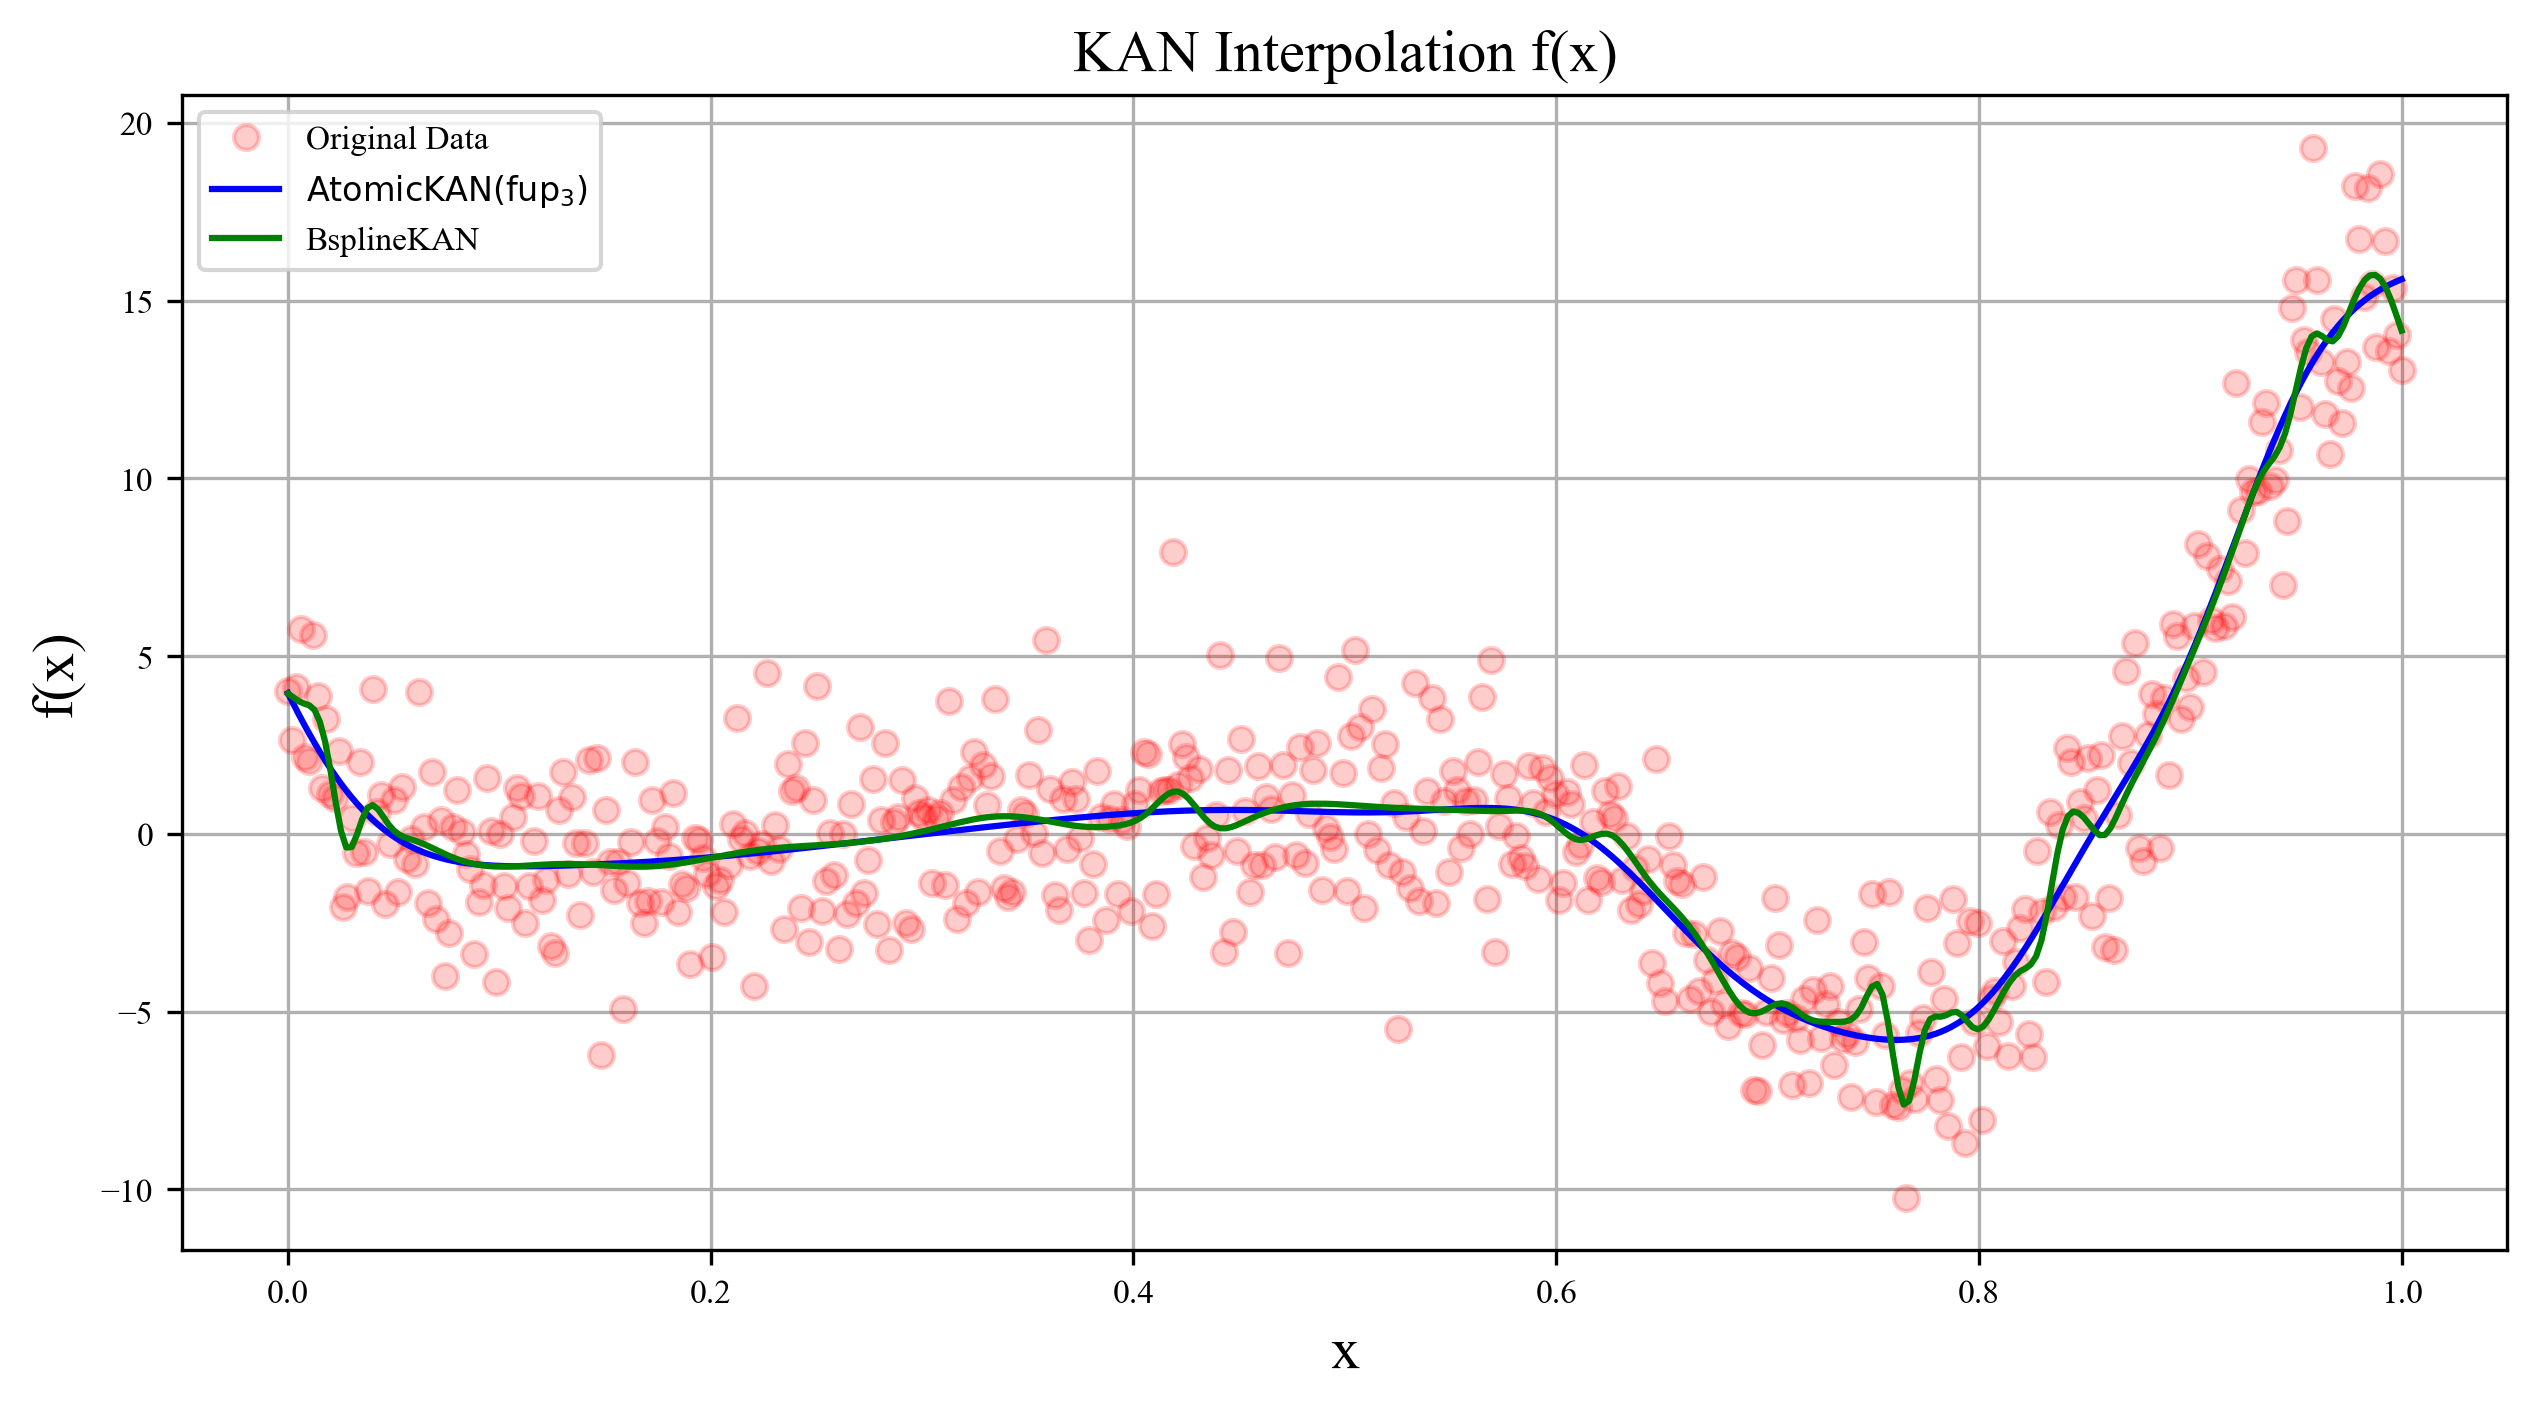

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original Data', alpha=0.2)
plt.plot(x_test.numpy(), y_pred_atom.numpy(), 'b-', label=r'$\mathrm{AtomicKAN (fup_3)}$')
plt.plot(x_test.numpy(), y_pred_bspline.numpy(), 'g-', label='BsplineKAN')
# plt.plot(x_test.numpy(), target_function2(x_test).numpy(), '-', color='orange', label='Original function')
plt.title('KAN Interpolation f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid()
plt.show()

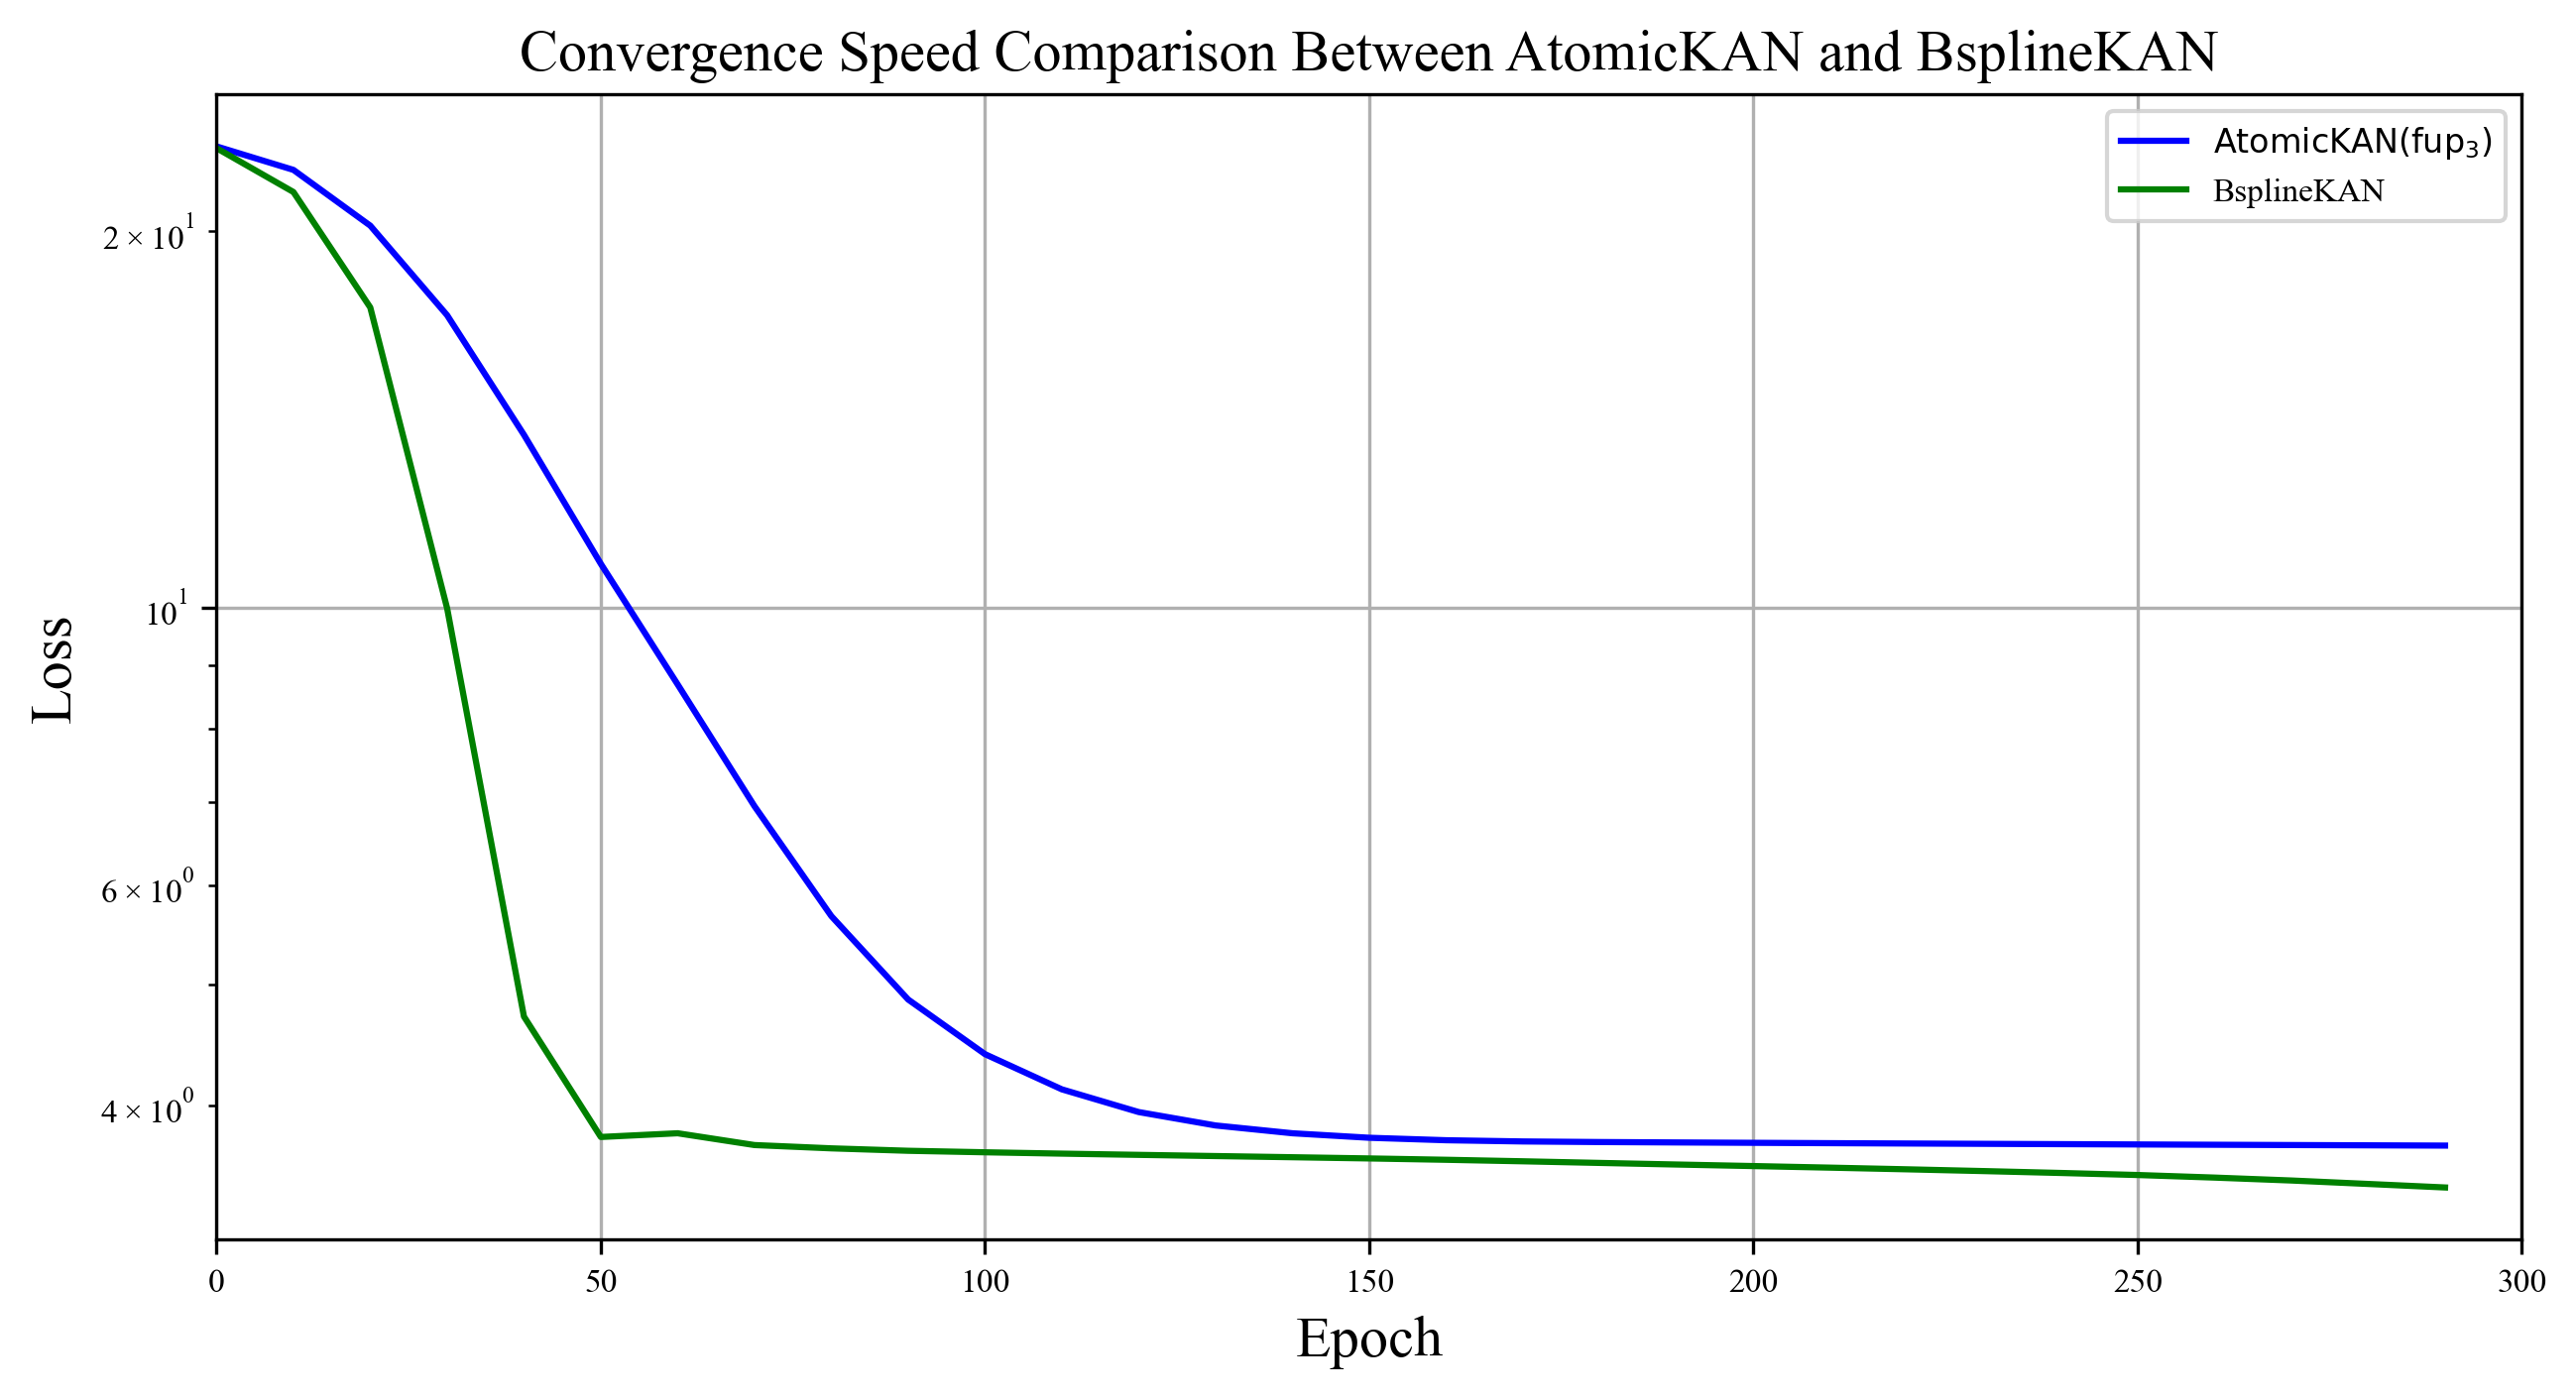

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, epoch_step), atom_losses, 'b-', label=r'$\mathrm{AtomicKAN (fup_3)}$')
plt.plot(range(0, epochs, epoch_step), bspline_losses, 'g-', label='BsplineKAN')
plt.title('Convergence Speed Comparison Between AtomicKAN and BsplineKAN')
plt.xlim(0, epochs)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

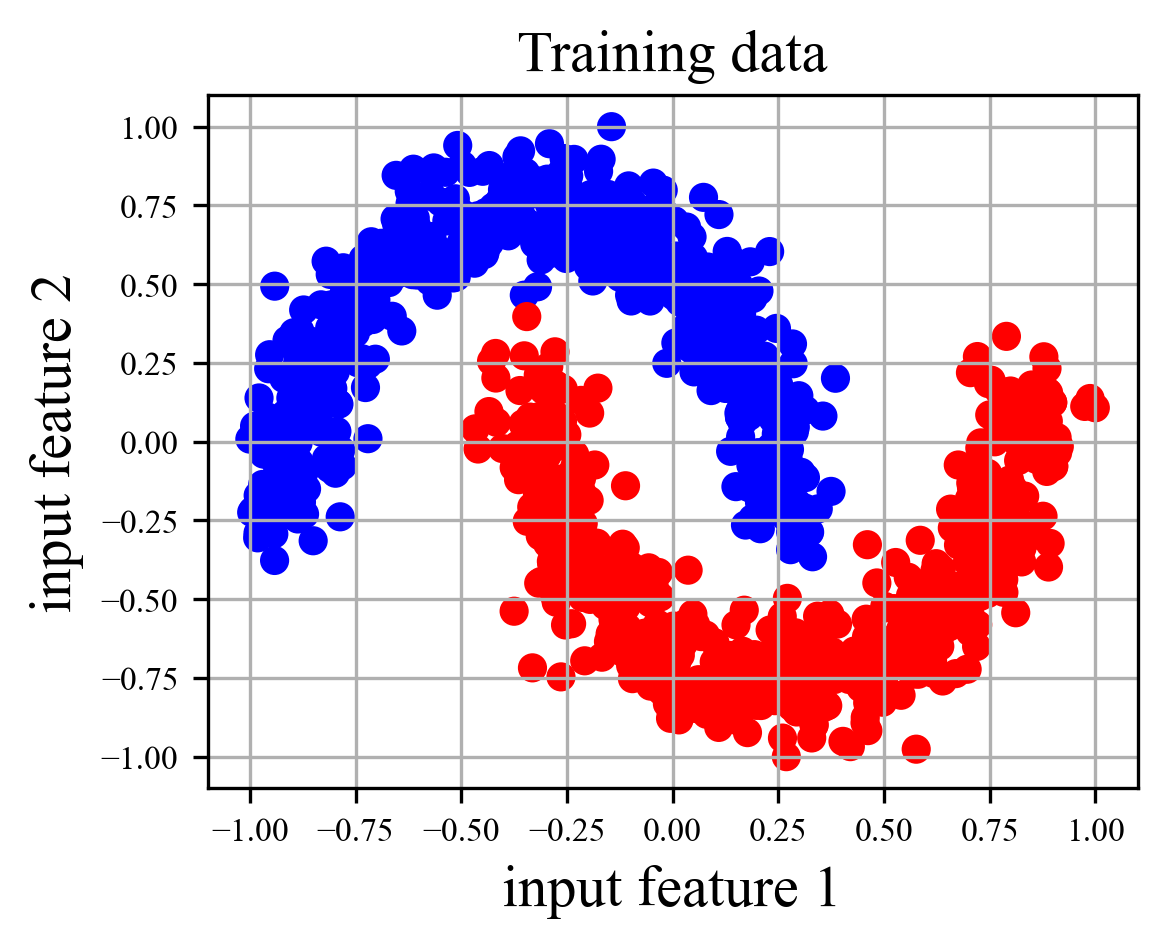

In [13]:
n_samples = 1000
noise = 0.1
x_train, y_train = datasets.make_moons(n_samples=n_samples, noise=noise)

# normalize between -1 and 1
x_train[:, 0] = (x_train[:, 0] - min(x_train[:, 0])) / max(x_train[:, 0] - min(x_train[:, 0])) * 2 - 1
x_train[:, 1] = (x_train[:, 1] - min(x_train[:, 1])) / max(x_train[:, 1] - min(x_train[:, 1])) * 2 - 1

fig, ax = plt.subplots(figsize=(4,3))
ax.scatter(*x_train.T, c=y_train, cmap=plt.cm.bwr)
ax.set_xlabel('input feature 1')
ax.set_ylabel('input feature 2')
ax.grid()
ax.set_title("Training data")
plt.show()

x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)

In [14]:
class AtomicKAN(nn.Module):
    def __init__(self):
        super(AtomicKAN, self).__init__()
        self.atomkan1 = AtomicKANLayer(2, 1, 8)

    def forward(self, x):
        x = self.atomkan1(x)
        return x

# Создаем модели
atomic_model = AtomicKAN()
bspline_model = KAN(width=[2, 1], grid=8, k=3, seed=42)

# Оптимизаторы для каждой модели
optimizer_atom = torch.optim.Adam(atomic_model.parameters(), lr=0.01)
optimizer_bspline = torch.optim.Adam(bspline_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Обучение
epochs = 200
atom_losses = []
bspline_losses = []

for epoch in range(epochs):
    # Обучение AtomicKAN
    optimizer_atom.zero_grad()
    outputs_atom = atomic_model(x_train)
    # Исправление размерностей
    loss_atom = criterion(outputs_atom.squeeze(), y_train)
    loss_atom.backward()
    optimizer_atom.step()

    # Обучение B-spline KAN
    optimizer_bspline.zero_grad()
    outputs_bspline = bspline_model(x_train)
    # Аналогичное исправление для B-spline модели
    loss_bspline = criterion(outputs_bspline.squeeze(), y_train)
    loss_bspline.backward()
    optimizer_bspline.step()

    if epoch % 10 == 0:
        atom_losses.append(loss_atom.item())
        bspline_losses.append(loss_bspline.item())
        print(f'Epoch {epoch + 1}/{epochs}, AtomicKAN Loss: {loss_atom.item():.4f}, B-spline Loss: {loss_bspline.item():.4f}')

checkpoint directory created: ./model
saving model version 0.0
Epoch 1/200, AtomicKAN Loss: 0.4693, B-spline Loss: 0.5881
Epoch 11/200, AtomicKAN Loss: 0.3035, B-spline Loss: 0.3958
Epoch 21/200, AtomicKAN Loss: 0.1868, B-spline Loss: 0.2297
Epoch 31/200, AtomicKAN Loss: 0.1178, B-spline Loss: 0.1196
Epoch 41/200, AtomicKAN Loss: 0.0827, B-spline Loss: 0.0738
Epoch 51/200, AtomicKAN Loss: 0.0642, B-spline Loss: 0.0578
Epoch 61/200, AtomicKAN Loss: 0.0521, B-spline Loss: 0.0454
Epoch 71/200, AtomicKAN Loss: 0.0438, B-spline Loss: 0.0376
Epoch 81/200, AtomicKAN Loss: 0.0383, B-spline Loss: 0.0334
Epoch 91/200, AtomicKAN Loss: 0.0345, B-spline Loss: 0.0305
Epoch 101/200, AtomicKAN Loss: 0.0319, B-spline Loss: 0.0285
Epoch 111/200, AtomicKAN Loss: 0.0300, B-spline Loss: 0.0273
Epoch 121/200, AtomicKAN Loss: 0.0287, B-spline Loss: 0.0266
Epoch 131/200, AtomicKAN Loss: 0.0278, B-spline Loss: 0.0261
Epoch 141/200, AtomicKAN Loss: 0.0272, B-spline Loss: 0.0258
Epoch 151/200, AtomicKAN Loss: 0.

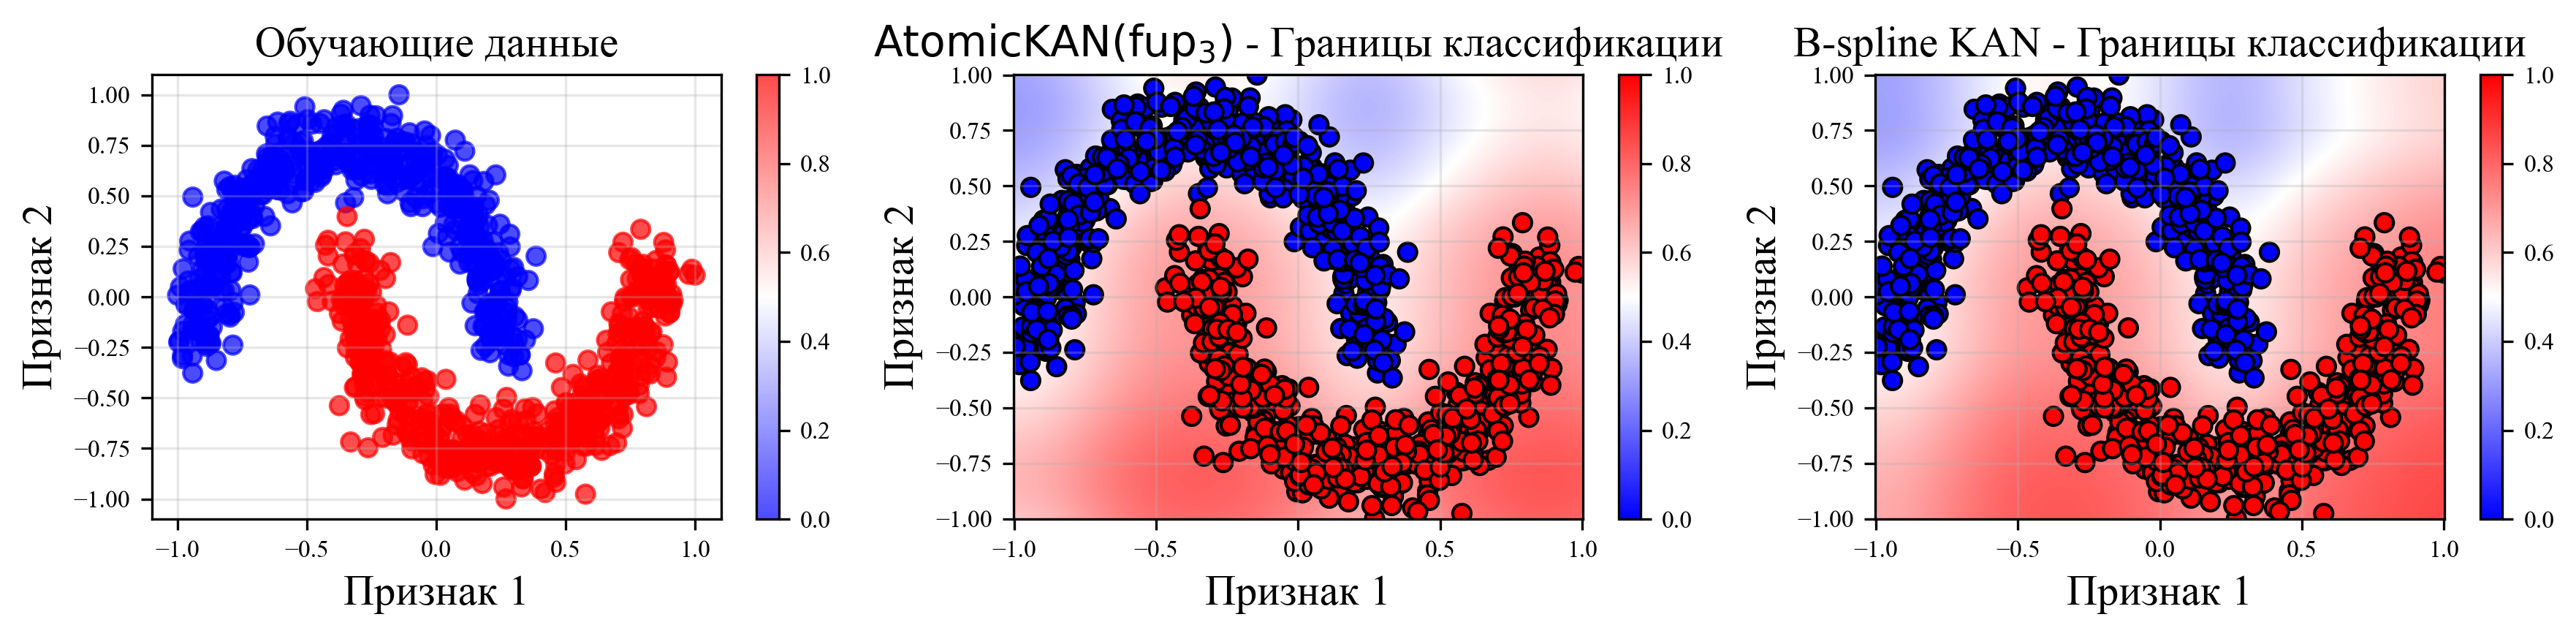

In [15]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Создаем сетку для визуализации
X1, X2 = np.meshgrid(np.linspace(-1, 1, 500), np.linspace(-1, 1, 500))
x_grid = np.concatenate((X1.reshape(-1, 1), X2.reshape(-1, 1)), axis=1)

# Преобразуем в тензоры для предсказания
x_grid_tensor = torch.FloatTensor(x_grid)

# Получаем предсказания от обеих моделей
with torch.no_grad():
    # AtomicKAN предсказания
    atomic_preds = atomic_model(x_grid_tensor).numpy()
    # B-spline KAN предсказания
    bspline_preds = bspline_model(x_grid_tensor).numpy()

# Преобразуем предсказания через сигмоиду для вероятностей
Y_atomic = sigmoid(atomic_preds).reshape(X1.shape)
Y_bspline = sigmoid(bspline_preds).reshape(X1.shape)

# Визуализация результатов
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# 1. Исходные данные
sc0 = axes[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=plt.cm.bwr, alpha=0.7)
axes[0].set_title('Обучающие данные')
axes[0].set_xlabel('Признак 1')
axes[0].set_ylabel('Признак 2')
axes[0].grid(True, alpha=0.3)
plt.colorbar(sc0, ax=axes[0])

# 2. AtomicKAN результаты
im1 = axes[1].pcolor(X1, X2, Y_atomic,  vmin=0, vmax=1, cmap=plt.cm.bwr)
axes[1].scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=plt.cm.bwr, edgecolors='black')
axes[1].set_title(r'$\mathrm{AtomicKAN (fup_3)}$' + ' - Границы классификации')
axes[1].set_xlabel('Признак 1')
axes[1].set_ylabel('Признак 2')
axes[1].grid(True, alpha=0.3)
plt.colorbar(im1, ax=axes[1])

# 3. B-spline KAN результаты
im2 = axes[2].pcolor(X1, X2, Y_bspline,  vmin=0, vmax=1, cmap=plt.cm.bwr)
axes[2].scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=plt.cm.bwr, edgecolors='black')
axes[2].set_title('B-spline KAN - Границы классификации')
axes[2].set_xlabel('Признак 1')
axes[2].set_ylabel('Признак 2')
axes[2].grid(True, alpha=0.3)
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

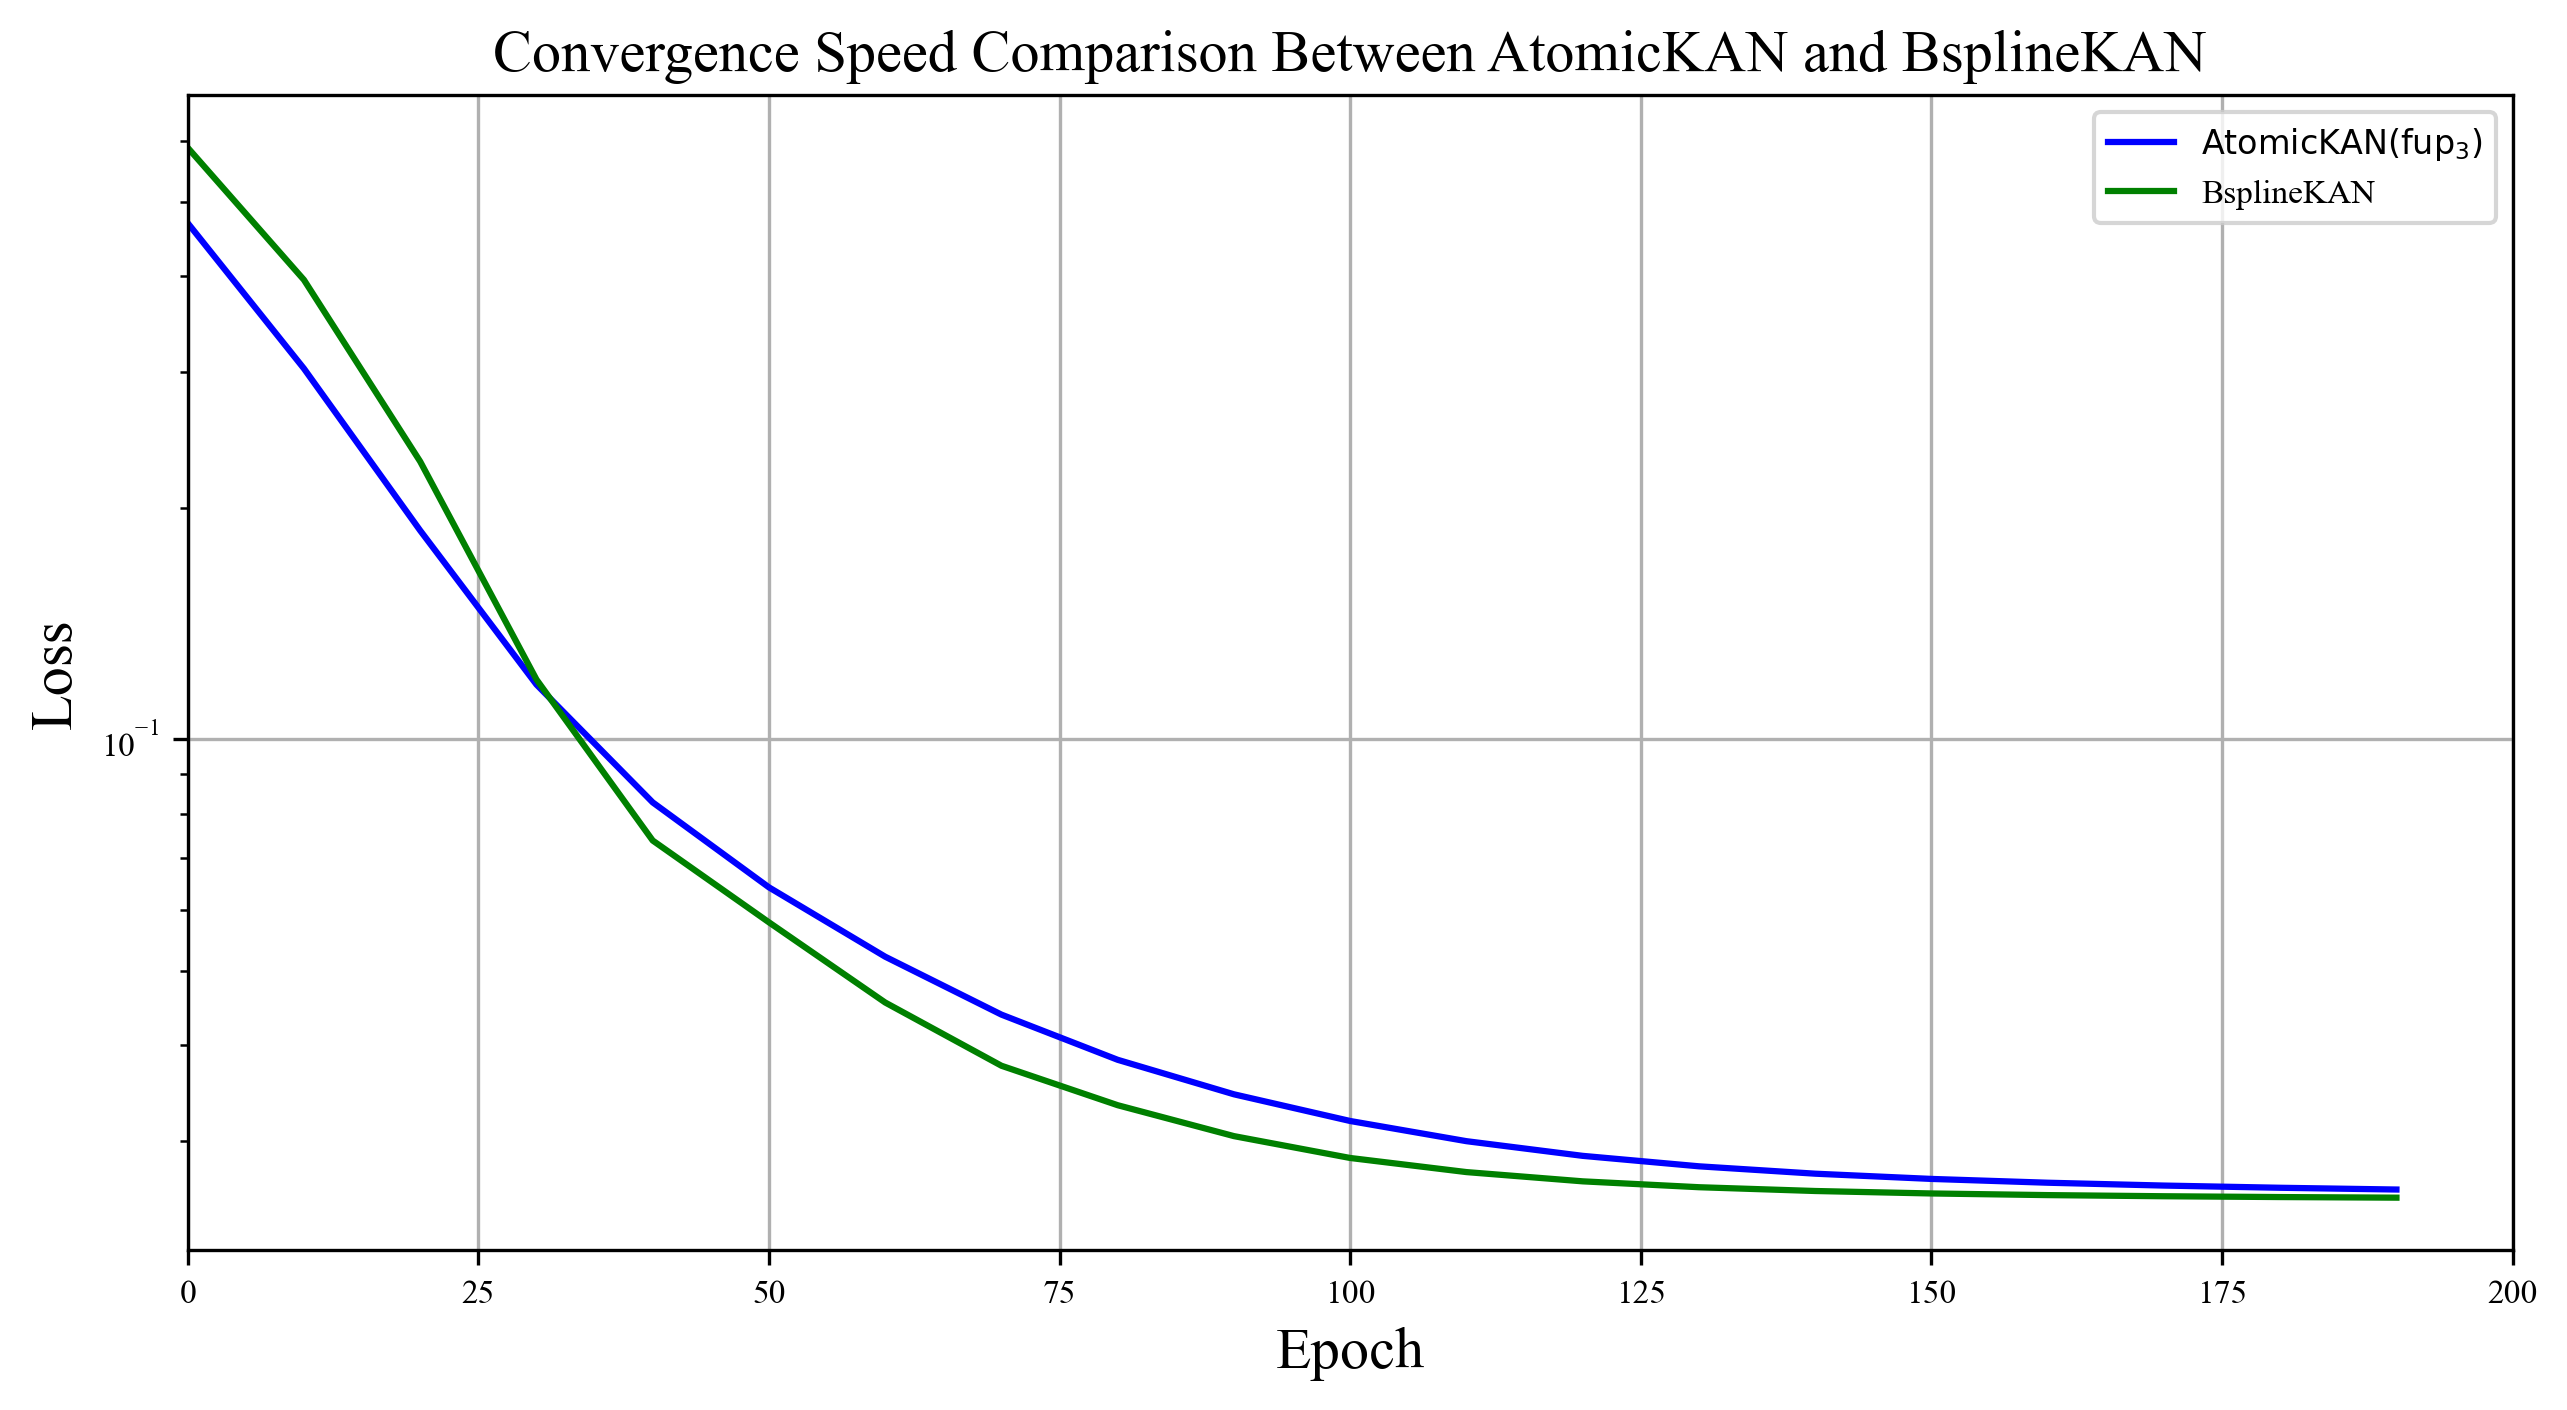

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, epoch_step), atom_losses, 'b-', label=r'$\mathrm{AtomicKAN (fup_3)}$')
plt.plot(range(0, epochs, epoch_step), bspline_losses, 'g-', label='BsplineKAN')
plt.title('Convergence Speed Comparison Between AtomicKAN and BsplineKAN')
plt.xlim(0, epochs)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

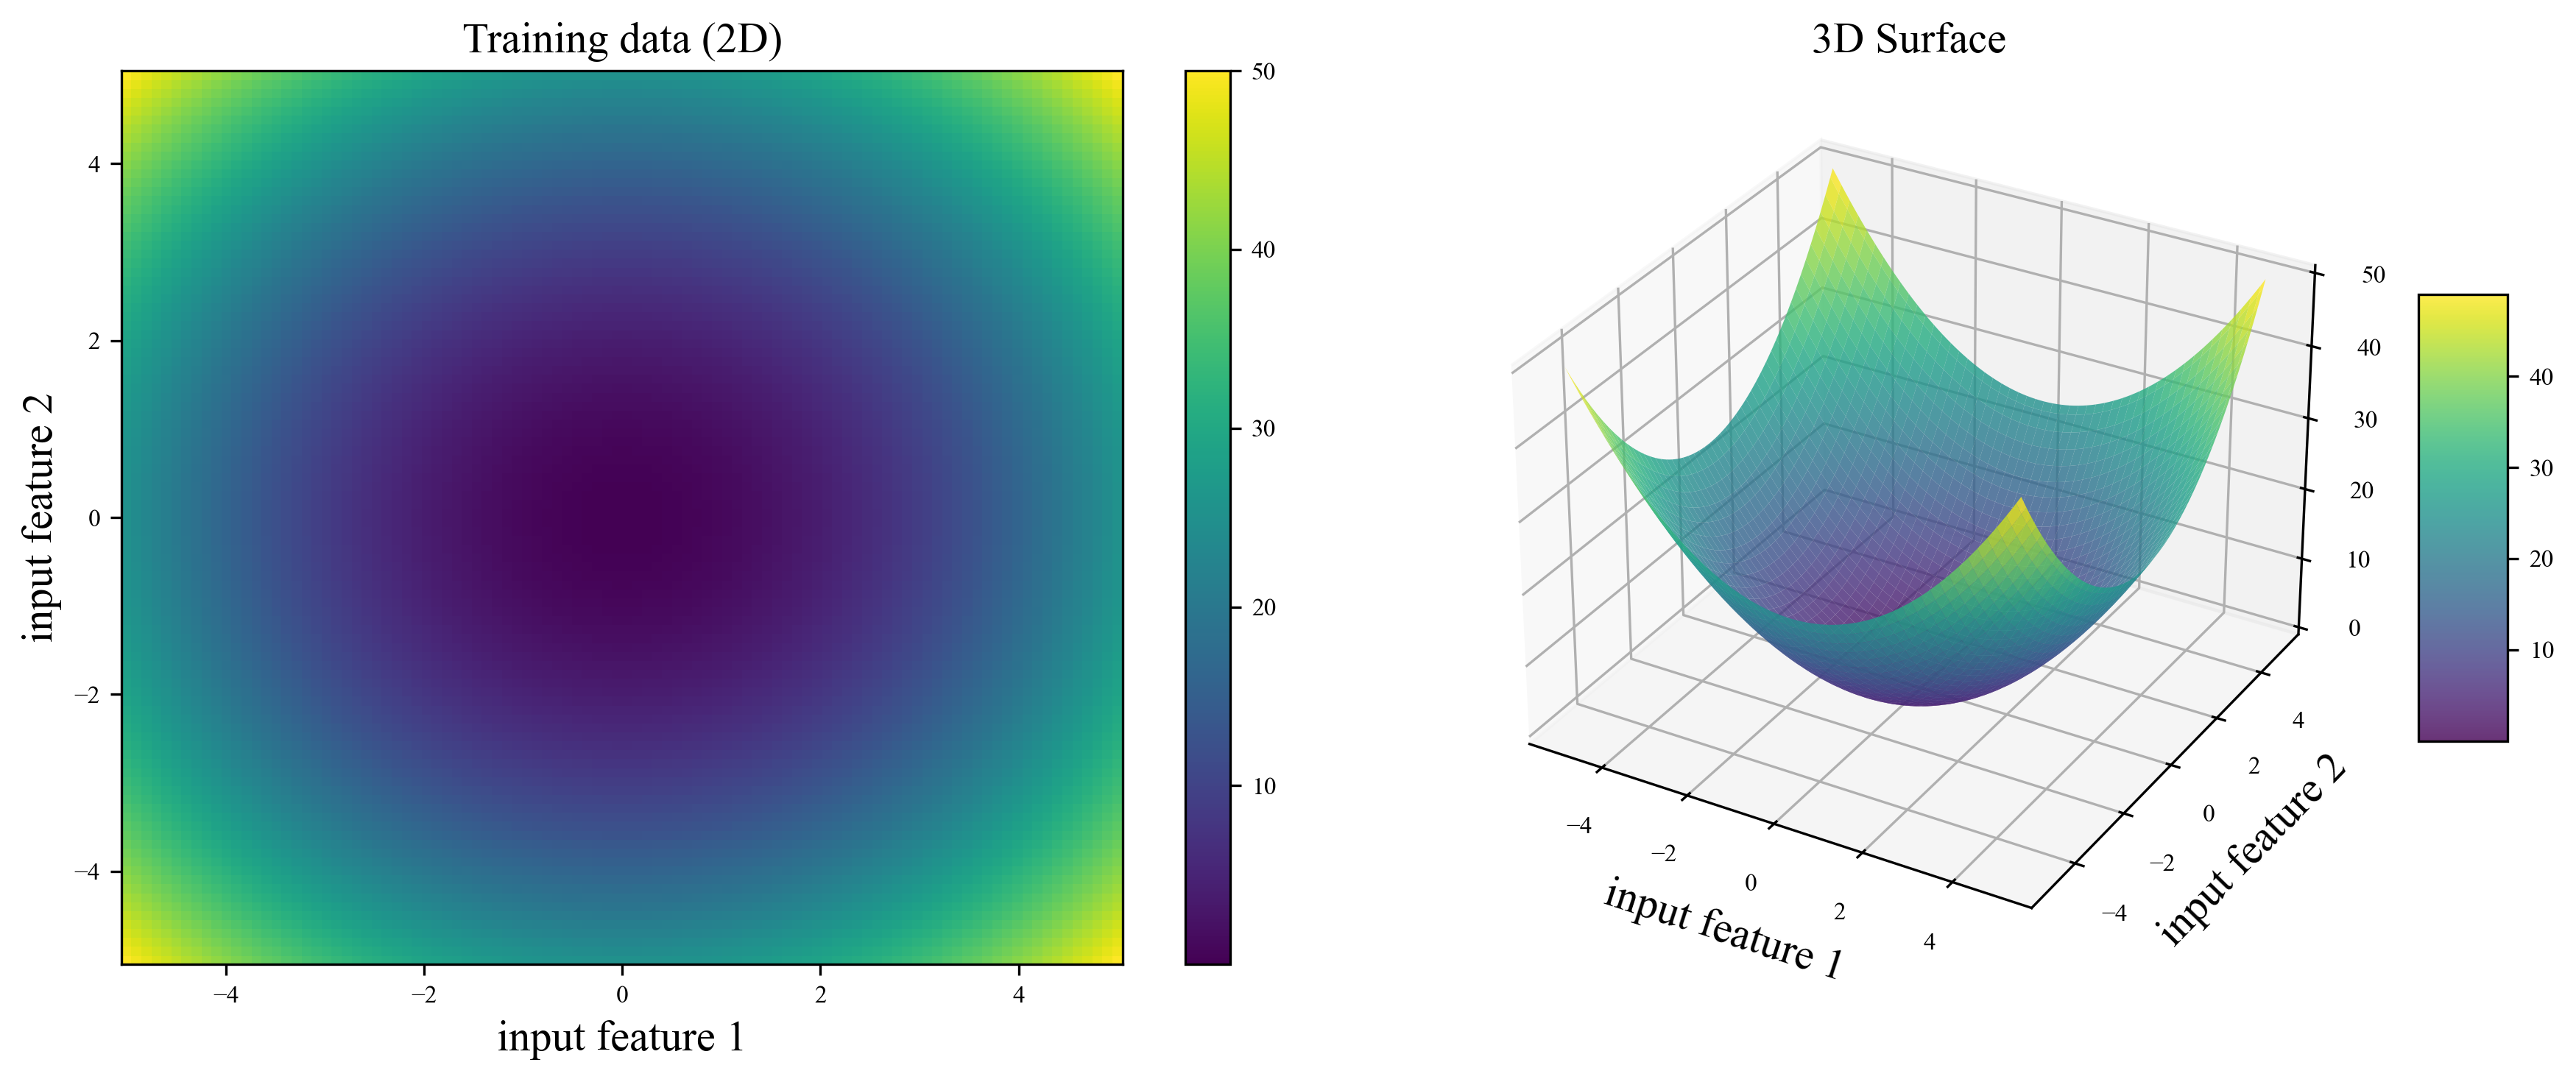

In [17]:
X1, X2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
Y_training = Sphere_function(X1, X2)

fig = plt.figure(figsize=(12, 5))

# Первый подграфик - 2D цветовая карта
ax1 = fig.add_subplot(1, 2, 1)
im = ax1.pcolor(X1, X2, Y_training, shading='auto')
ax1.set_xlabel('input feature 1')
ax1.set_ylabel('input feature 2')
ax1.set_title('Training data (2D)')
plt.colorbar(im, ax=ax1)

# Второй подграфик - 3D поверхность
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax2.plot_surface(X1, X2, Y_training, cmap='viridis', alpha=0.8)
ax2.set_xlabel('input feature 1')
ax2.set_ylabel('input feature 2')
ax2.set_title('3D Surface')

# Добавляем цветовую шкалу для 3D графика
fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

In [18]:
class AtomicKAN(nn.Module):
    def __init__(self):
        super(AtomicKAN, self).__init__()
        self.chebykan1 = AtomicKANLayer(2, 8, 8)
        self.chebykan2 = AtomicKANLayer(8, 16, 4)
        self.chebykan3 = AtomicKANLayer(16, 1, 4)

    def forward(self, x):
        x = self.chebykan1(x)
        x = self.chebykan2(x)
        x = self.chebykan3(x)
        return x

In [ ]:
# Generate 2D sample data
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = Sphere_function(X, Y)
x_train_2d = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)
y_train_2d = torch.tensor(Z.ravel(), dtype=torch.float32).unsqueeze(1)


AtomicKAN_model = AtomicKAN()
BsplineKAN_model = KAN(width=[2, 8, 16, 1], grid=8, k=3, seed=42)

criterion = nn.MSELoss()
optimizer_bspline = torch.optim.Adam(BsplineKAN_model.parameters(), lr=0.01)
optimizer_atomic = torch.optim.Adam(AtomicKAN_model.parameters(), lr=0.01)


bspline_losses = []
atomic_losses = []


# Train the models
# epochs = 2000
epochs = 1000
epoch_step = 10
for epoch in range(epochs):
    # MLP Training
    optimizer_bspline.zero_grad()
    outputs_mlp = BsplineKAN_model(x_train_2d)
    loss_mlp = criterion(outputs_mlp, y_train_2d)
    loss_mlp.backward()
    optimizer_bspline.step()

    # AtomicKAN Training
    optimizer_atomic.zero_grad()
    outputs_cheby = AtomicKAN_model(x_train_2d)
    loss_cheby = criterion(outputs_cheby, y_train_2d)
    loss_cheby.backward()
    optimizer_atomic.step()

    if epoch % epoch_step == 0:
        atomic_losses.append(loss_cheby.item())
        bspline_losses.append(loss_mlp.item())
        print(f'Epoch {epoch+1}/{epochs}, BsplineKAN Loss: {loss_mlp.item():.4f}, AtomicKAN Loss: {loss_cheby.item():.4f}')




checkpoint directory created: ./model
saving model version 0.0
Epoch 1/1000, BsplineKAN Loss: 406.7384, AtomicKAN Loss: 407.1685
Epoch 11/1000, BsplineKAN Loss: 359.8993, AtomicKAN Loss: 352.2932
Epoch 21/1000, BsplineKAN Loss: 264.8787, AtomicKAN Loss: 300.4883
Epoch 31/1000, BsplineKAN Loss: 129.9757, AtomicKAN Loss: 249.8463
Epoch 41/1000, BsplineKAN Loss: 97.6899, AtomicKAN Loss: 203.8820
Epoch 51/1000, BsplineKAN Loss: 70.8425, AtomicKAN Loss: 166.3834
Epoch 61/1000, BsplineKAN Loss: 53.8464, AtomicKAN Loss: 139.6367
Epoch 71/1000, BsplineKAN Loss: 41.2517, AtomicKAN Loss: 117.8039
Epoch 81/1000, BsplineKAN Loss: 32.2496, AtomicKAN Loss: 97.8078
Epoch 91/1000, BsplineKAN Loss: 26.5944, AtomicKAN Loss: 83.9808
Epoch 101/1000, BsplineKAN Loss: 22.3337, AtomicKAN Loss: 76.0506
Epoch 111/1000, BsplineKAN Loss: 18.6094, AtomicKAN Loss: 72.1313
Epoch 121/1000, BsplineKAN Loss: 15.2882, AtomicKAN Loss: 69.9260
Epoch 131/1000, BsplineKAN Loss: 12.7110, AtomicKAN Loss: 67.8646
Epoch 141/10

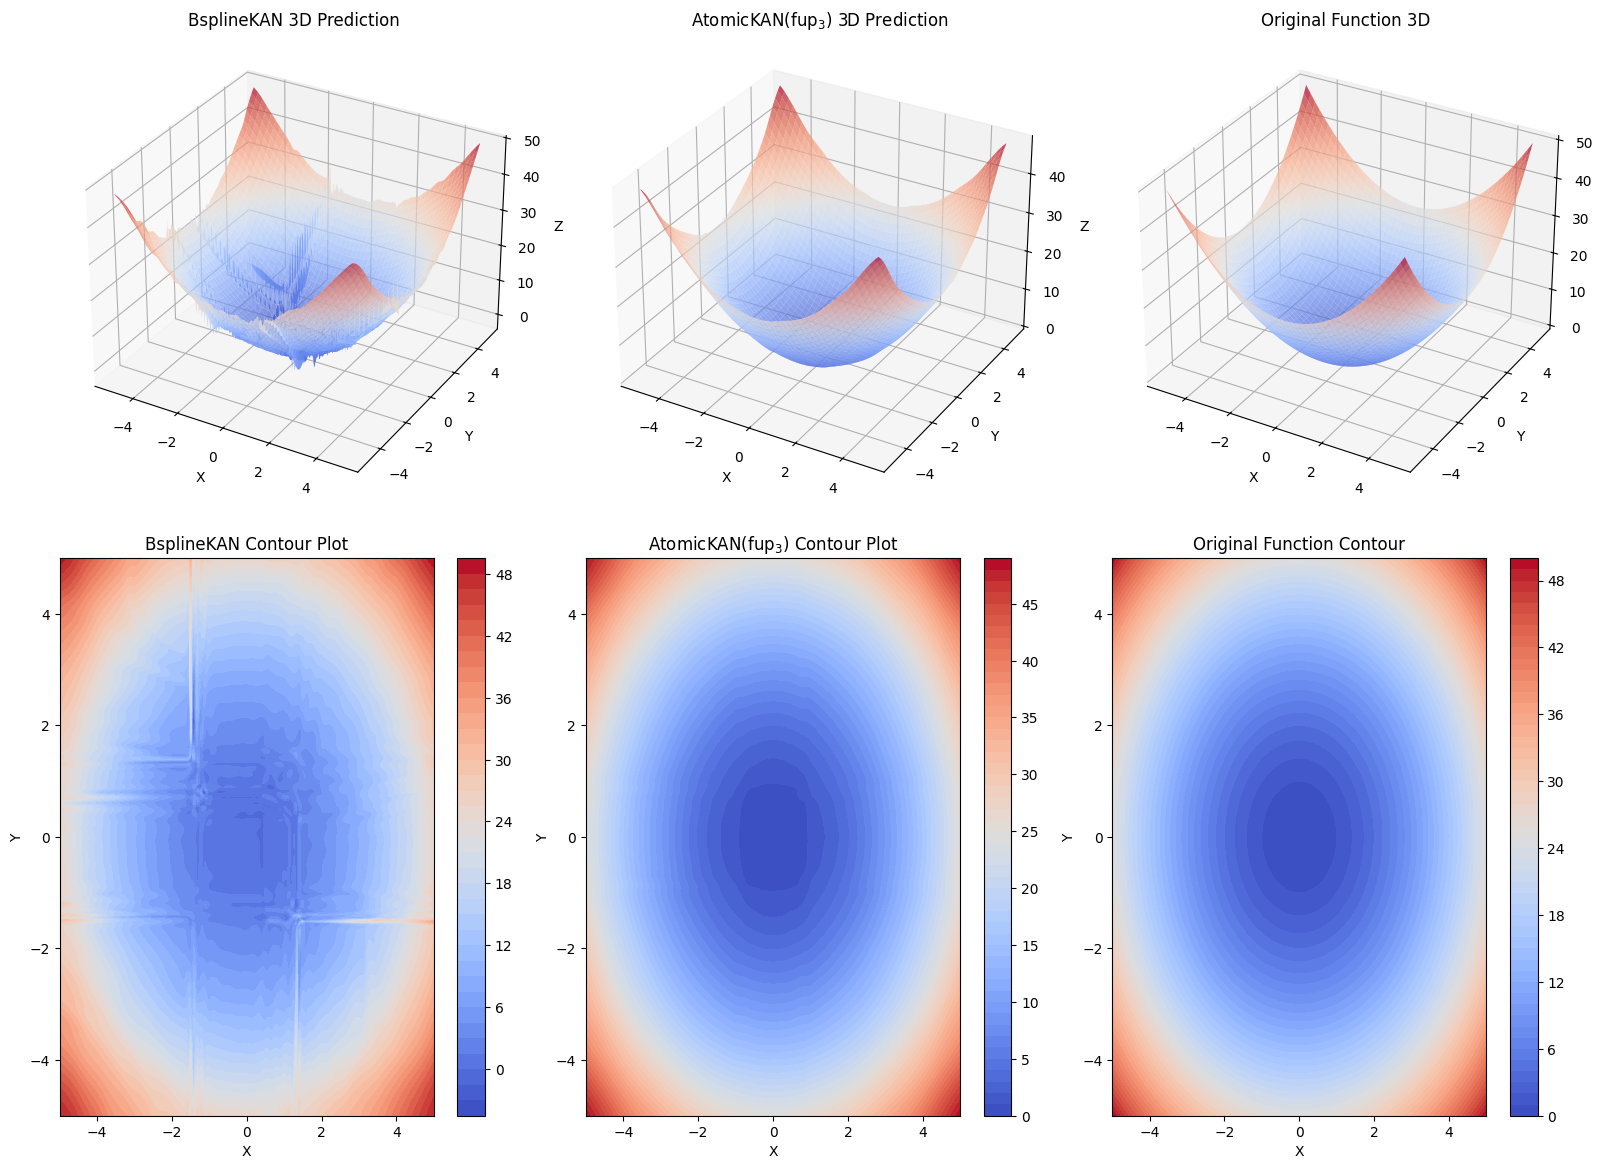

In [49]:
# Test the models
x_test = np.linspace(-5, 5, 400)
y_test = np.linspace(-5, 5, 400)
X_test, Y_test = np.meshgrid(x_test, y_test)
Z_test = Sphere_function(X_test, Y_test)
x_test_2d = torch.tensor(np.stack([X_test.ravel(), Y_test.ravel()], axis=1), dtype=torch.float32)
y_pred_bspline = BsplineKAN_model(x_test_2d).detach().numpy()
y_pred_atomic = AtomicKAN_model(x_test_2d).detach().numpy()

# Plot the results using a 3D plot
fig = plt.figure(figsize=(16, 12))

# Первый столбец: BsplineKAN
# 3D график
ax1 = fig.add_subplot(231, projection='3d')
surf1 = ax1.plot_surface(X_test, Y_test, y_pred_bspline.reshape(X_test.shape), cmap='coolwarm', alpha=0.7)
ax1.set_title('BsplineKAN 3D Prediction')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Контурный график
ax4 = fig.add_subplot(234)
contour1 = ax4.contourf(X_test, Y_test, y_pred_bspline.reshape(X_test.shape), levels=50, cmap='coolwarm')
ax4.set_title('BsplineKAN Contour Plot')
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
plt.colorbar(contour1, ax=ax4)

# Второй столбец: AtomicKAN
# 3D график
ax2 = fig.add_subplot(232, projection='3d')
surf2 = ax2.plot_surface(X_test, Y_test, y_pred_atomic.reshape(X_test.shape), cmap='coolwarm', alpha=0.7)
ax2.set_title(r'$\mathrm{AtomicKAN (fup_3)}$' + ' 3D Prediction')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# Контурный график
ax5 = fig.add_subplot(235)
contour2 = ax5.contourf(X_test, Y_test, y_pred_atomic.reshape(X_test.shape), levels=50, cmap='coolwarm')
ax5.set_title(r'$\mathrm{AtomicKAN (fup_3)}$' + ' Contour Plot')
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
plt.colorbar(contour2, ax=ax5)

# Третий столбец: Original Function
# 3D график
ax3 = fig.add_subplot(233, projection='3d')
surf3 = ax3.plot_surface(X_test, Y_test, Z_test, cmap='coolwarm', alpha=0.7)
ax3.set_title('Original Function 3D')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

# Контурный график
ax6 = fig.add_subplot(236)
contour3 = ax6.contourf(X_test, Y_test, Z_test, levels=50, cmap='coolwarm')
ax6.set_title('Original Function Contour')
ax6.set_xlabel('X')
ax6.set_ylabel('Y')
plt.colorbar(contour3, ax=ax6)

plt.tight_layout()
plt.show()

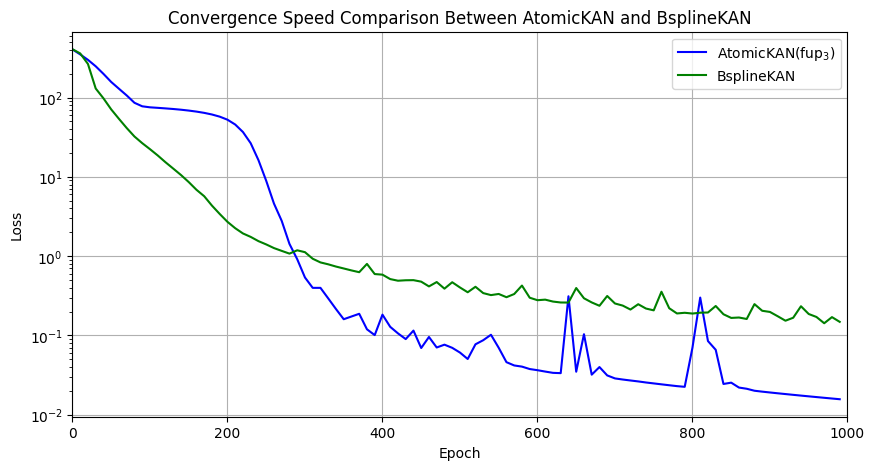

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, epoch_step), atomic_losses, 'b-', label=r'$\mathrm{AtomicKAN (fup_3)}$')
plt.plot(range(0, epochs, epoch_step), bspline_losses, 'g-', label='BsplineKAN')
plt.title('Convergence Speed Comparison Between AtomicKAN and BsplineKAN')
plt.xlim(0, epochs)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()